<a href="https://colab.research.google.com/github/KaustubhRatna/Deep-Learning-Projects/blob/main/DR_detection_on_Aptos_Dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/retinopathy dataset",
                                                    shuffle=True,
                                                    image_size = (IMAGE_SIZE,IMAGE_SIZE), 
                                                    batch_size = BATCH_SIZE)

Found 3662 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['defected', 'healthy']

# Data Visualization

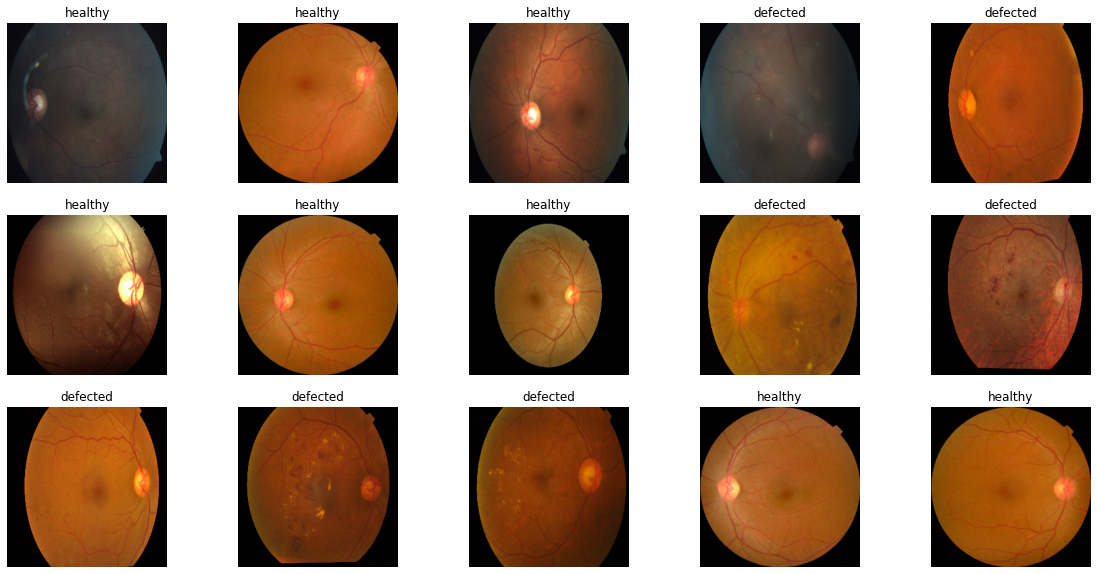

In [ ]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

115

# Train Test split

In [ ]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds

In [ ]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
# performance improving by using both CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Processing

In [ ]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Training

## Basic CNN architecture 

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 2


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
#model training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=3
    
)

Epoch 1/3
92/92 [==============================] - 1310s 4s/step - loss: 0.5883 - accuracy: 0.6634 - val_loss: 0.3772 - val_accuracy: 0.8636
Epoch 2/3
92/92 [==============================] - 9s 95ms/step - loss: 0.3735 - accuracy: 0.8421 - val_loss: 0.3395 - val_accuracy: 0.8210
Epoch 3/3
92/92 [==============================] - 9s 93ms/step - loss: 0.2752 - accuracy: 0.8889 - val_loss: 0.2677 - val_accuracy: 0.9205


In [ ]:
scores = model.evaluate(test_ds)
scores

KeyboardInterrupt: ignored

In [ ]:
y_pred=model.predict(test_ds)

12/12 [==============================] - 1s 37ms/step


In [ ]:
print(type(y_pred))
print(y_pred[0])
np.argmax(y_pred[0])
len(y_pred)

<class 'numpy.ndarray'>
[1.0023973e-06 9.9997437e-01]


366

In [ ]:
import tensorflow_datasets as tfds
test_ds_numpy = tfds.as_numpy(test_ds) 

In [ ]:
len(test_ds_numpy)

12

In [ ]:
for i in range(0,366):
    if np.argmax(y_pred[i]) == 1:
      print("Predicted Healthy")
    else:
      print("Predicted Defected")

Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Healthy
Predic

In [ ]:
test_ds_labels = np.concatenate([y for x, y in test_ds], axis=0)

NameError: ignored

In [ ]:
len(test_ds_labels)
type(test_ds_labels)

numpy.ndarray

In [ ]:
history

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 92}


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.659307062625885,
 0.8692255616188049,
 0.87669837474823,
 0.8807744383811951,
 0.895380437374115,
 0.9052309989929199,
 0.914402186870575,
 0.923233687877655,
 0.92527174949646,
 0.929347813129425,
 0.938858687877655,
 0.9402173757553101,
 0.9402173757553101,
 0.9453125,
 0.950067937374115,
 0.946671187877655,
 0.9453125,
 0.9510869383811951,
 0.957880437374115,
 0.961277186870575,
 0.954483687877655,
 0.960597813129425,
 0.9599184989929199,
 0.959578812122345,
 0.9582201242446899,
 0.9660326242446899,
 0.9697690010070801,
 0.96535325050354,
 0.967391312122345,
 0.970108687877655,
 0.970108687877655,
 0.97044837474823,
 0.9755434989929199,
 0.9714673757553101,
 0.9724864363670349,
 0.97044837474823,
 0.971807062625885,
 0.9738451242446899,
 0.9724864363670349,
 0.973505437374115,
 0.9741848111152649,
 0.977921187877655,
 0.9697690010070801,
 0.973505437374115,
 0.9714673757553101,
 0.9697690010070801,
 0.9745244383811951,
 0.976902186870575,
 0.9758831262588501,
 0.976902186870575]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy over 50 epochs')

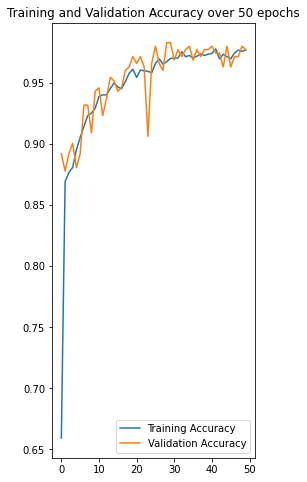

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy over 50 epochs")


Text(0.5, 1.0, 'Training  and Validation Loss over 50 epochs')

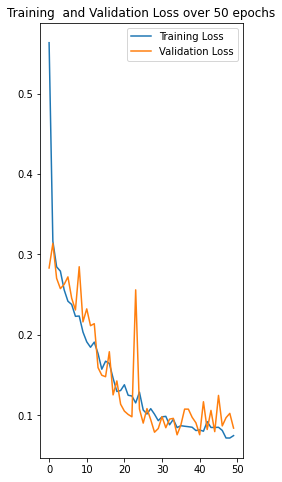

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss,label='Training Loss')
plt.plot(range(50),val_loss,label='Validation Loss')
plt.legend(loc="upper right")
plt.title("Training  and Validation Loss over 50 epochs")

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(test_ds_labels)

[1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1
 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1
 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0
 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0
 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0
 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1]


In [ ]:
y_pred_labels =[]
for i in range(0,366):
    if np.argmax(y_pred[i]) == 1:
      y_pred_labels.append(1)
    else:
      y_pred_labels.append(0)

y_pred_labels=np.array(y_pred_labels)

In [ ]:
print(y_pred_labels)

[1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0
 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1
 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0
 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1]


In [ ]:
cm = confusion_matrix(test_ds_labels, y_pred_labels)

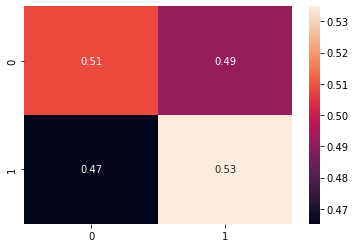

In [ ]:
from sklearn.preprocessing import normalize
import seaborn as sns
normed_confusion_matrix = normalize(cm , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)

<ipython-input-48-5263b2d5121d>:16: MatplotlibDeprecationWarning: Unrecognized location 'lower\xa0right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc="lower right")


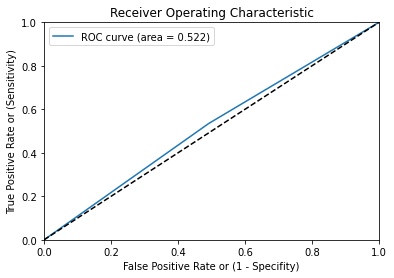

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_ds_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [ ]:
model_version = 1
model.save(f"/content/drive/MyDrive/retinopathy dataset/{model_version}")

# ResNet 50

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 2

resnet_model = tf.keras.applications.ResNet50(
    input_shape=(256,256,3), 
    include_top=False, 
    weights='imagenet'
)

resnet_model.trainable =False

resnet_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
resnettrain = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

resnettrain.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                2097168   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                      

In [ ]:
resnettrain.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = resnettrain.fit(
    train_ds,
    batch_size=128,
    validation_data=valid_ds,
    verbose=1,
    epochs=50
    
)

Epoch 1/50
92/92 [==============================] - 19s 164ms/step - loss: 0.5177 - accuracy: 0.7599 - val_loss: 0.3543 - val_accuracy: 0.9375
Epoch 2/50
92/92 [==============================] - 14s 151ms/step - loss: 0.4042 - accuracy: 0.8346 - val_loss: 0.3109 - val_accuracy: 0.9403
Epoch 3/50
92/92 [==============================] - 13s 146ms/step - loss: 0.3558 - accuracy: 0.8611 - val_loss: 0.2241 - val_accuracy: 0.9631
Epoch 4/50
92/92 [==============================] - 13s 144ms/step - loss: 0.3169 - accuracy: 0.8879 - val_loss: 0.1888 - val_accuracy: 0.9631
Epoch 5/50
92/92 [==============================] - 13s 145ms/step - loss: 0.2671 - accuracy: 0.9052 - val_loss: 0.1483 - val_accuracy: 0.9631
Epoch 6/50
92/92 [==============================] - 13s 146ms/step - loss: 0.2555 - accuracy: 0.9124 - val_loss: 0.1538 - val_accuracy: 0.9659
Epoch 7/50
92/92 [==============================] - 14s 148ms/step - loss: 0.2418 - accuracy: 0.9096 - val_loss: 0.1204 - val_accuracy: 0.9688

In [ ]:
scores = model.evaluate(test_ds)
scores

12/12 [==============================] - 0s 36ms/step - loss: 0.1043 - accuracy: 0.9645


[0.10433485358953476, 0.9644808769226074]

In [ ]:
y_pred=model.predict(test_ds)

12/12 [==============================] - 0s 32ms/step


In [ ]:
print(type(y_pred))
print(y_pred[0])
np.argmax(y_pred[0])
len(y_pred)

<class 'numpy.ndarray'>
[1.0023973e-06 9.9997437e-01]


366

In [ ]:
import tensorflow_datasets as tfds
test_ds_numpy = tfds.as_numpy(test_ds) 

In [ ]:
len(test_ds_numpy)

12

In [ ]:
for i in range(0,366):
    if np.argmax(y_pred[i]) == 1:
      print("Predicted Healthy")
    else:
      print("Predicted Defected")


Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Healthy
Predicted Healthy
Predicted Defected
Predicted Defected
Predicted Healthy
Predicted Defected


In [ ]:
test_ds_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
len(test_ds_labels)
type(test_ds_labels)

numpy.ndarray

In [ ]:
history

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 92}


In [ ]:
history.history['accuracy']

[0.7598505616188049,
 0.834578812122345,
 0.86107337474823,
 0.8879076242446899,
 0.9052309989929199,
 0.91236412525177,
 0.90964674949646,
 0.9296875,
 0.93138587474823,
 0.937160313129425,
 0.9459918737411499,
 0.94191575050354,
 0.951766312122345,
 0.9541440010070801,
 0.9507473111152649,
 0.9568614363670349,
 0.9541440010070801,
 0.9558423757553101,
 0.9568614363670349,
 0.9538043737411499,
 0.957880437374115,
 0.957880437374115,
 0.959578812122345,
 0.96535325050354,
 0.9588994383811951,
 0.9599184989929199,
 0.9680706262588501,
 0.9680706262588501,
 0.97044837474823,
 0.9677309989929199,
 0.9633151888847351,
 0.960597813129425,
 0.96433424949646,
 0.965692937374115,
 0.96875,
 0.9680706262588501,
 0.9650135636329651,
 0.9619565010070801,
 0.9680706262588501,
 0.969089686870575,
 0.9728260636329651,
 0.96875,
 0.9714673757553101,
 0.96875,
 0.97486412525177,
 0.9714673757553101,
 0.965692937374115,
 0.975203812122345,
 0.9755434989929199,
 0.97214674949646]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy over 50 epochs')

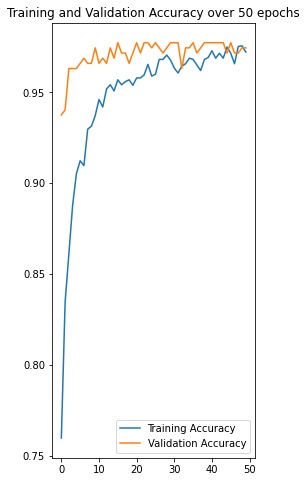

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy over 50 epochs")


Text(0.5, 1.0, 'Training  and Validation Loss over 50 epochs')

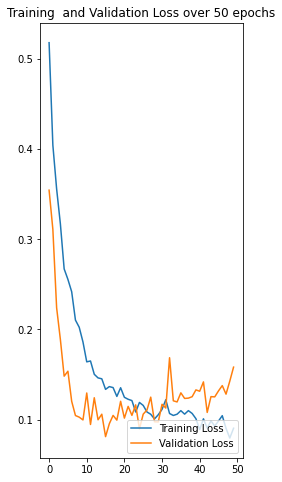

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(50),loss,label='Training Loss')
plt.plot(range(50),val_loss,label='Validation Loss')
plt.legend(loc="lower right")
plt.title("Training  and Validation Loss over 50 epochs")

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(test_ds_labels)

[1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1
 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0
 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0
 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0
 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0
 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1
 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0]


In [ ]:
y_pred_labels =[]
for i in range(0,366):
    if np.argmax(y_pred[i]) == 1:
      y_pred_labels.append(1)
    else:
      y_pred_labels.append(0)

y_pred_labels=np.array(y_pred_labels)

In [ ]:
print(y_pred_labels)

[1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1
 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1
 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1
 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0
 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0
 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1]


In [ ]:
cm = confusion_matrix(test_ds_labels, y_pred_labels)

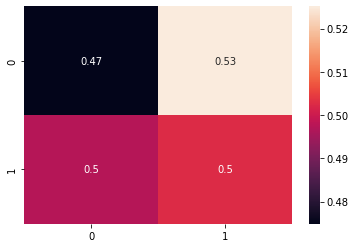

In [ ]:
from sklearn.preprocessing import normalize
import seaborn as sns
normed_confusion_matrix = normalize(cm , axis = 1, norm = 'l1')
cm_df = pd.DataFrame(normed_confusion_matrix)
sns.heatmap (cm_df , annot =True)

<ipython-input-77-5263b2d5121d>:16: MatplotlibDeprecationWarning: Unrecognized location 'lower\xa0right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc="lower right")


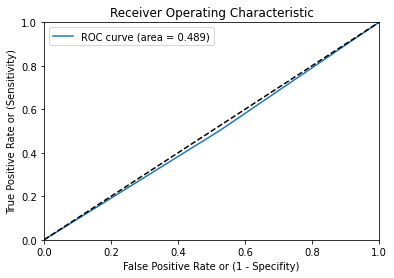

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_ds_labels, y_pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")